## 0. Imports

In [1]:
import requests
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets
import time
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.cm as cm
import numpy as np

In [2]:
# If True, always calls the API for new data. Otherwise saved data is used if available
refetch_data = False

In [3]:
# Paths
playlist_content_save_path = "./playlist_content_data.json"
album_content_save_path = "./album_content_data.json"
artist_content_save_path = "./artist_content_data.json"

## 1. Get Access Token
Use the spotify developer credentials in the `credentials.json` file to generate an access token (valid for 1 hour).

In [4]:
def get_spotify_access_token():
    # Read the credentials from the JSON file
    with open("credentials.json", 'r') as file:
        credentials = json.load(file)
        client_id = credentials["client_id"]
        client_secret = credentials["client_secret"]
        
    # Get access token from spotify
    url = "https://accounts.spotify.com/api/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials", "client_id": client_id, "client_secret": client_secret}

    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        print(f"Access token request failed, Status Code: {response.status_code}")
        return None

In [5]:
access_token = get_spotify_access_token()

## 2. Get Playlist Content
Fetch complete playlist data from a playlist id

In [6]:
def get_playlist_content(playlist_id, save_to_file=True):
    url = "https://api.spotify.com/v1/playlists/" + playlist_id
    headers = {"Authorization": "Bearer " + access_token}
    
    base_response = requests.get(url, headers=headers)
    print(f"Requested: {url}, Status Code: {base_response.status_code}")
    
    if base_response.status_code == 200:
        base_response_json = base_response.json()
        next_url = base_response_json["tracks"]["next"]
    else:
        print("Failed to fetch playlist data")
        return None        
    
    while next_url is not None:
        response = requests.get(next_url, headers=headers)
        print(f"Requested: {next_url}, Status Code: {response.status_code}")
        
        if response.status_code == 200:
            additional_tracks = response.json()
            base_response_json["tracks"]["items"].extend(additional_tracks["items"])
            next_url = additional_tracks["next"]
        else:
            print("Failed to fetch playlist data")
            return None

    if save_to_file:
        with open(playlist_content_save_path, "w") as save_file:
            json.dump(base_response_json, save_file)

    return base_response_json

In [7]:
if refetch_data or not os.path.exists(playlist_content_save_path):
    playlist_json = get_playlist_content(playlist_id="4hnDUcviGrwCf46xa7vzfR")
else:
    with open(playlist_content_save_path, "r") as save_file:
        playlist_json = json.load(save_file)
        print("Loaded data from save file")

Loaded data from save file


In [8]:
print(f"Length of playlist: {len(playlist_json['tracks']['items'])}")

Length of playlist: 360


In [9]:
print("Last five songs in playlist:")
tracks = playlist_json["tracks"]["items"]

for track in tracks[-5:]:
    name = track["track"]["name"]
    artists = [artist["name"] for artist in track["track"]["artists"]]
    print(" -", name, artists)

Last five songs in playlist:
 - I Can't Wait ['Sum 41']
 - Screaming Bloody Murder ['Sum 41']
 - Never There ['Sum 41']
 - Vices ['Silverstein']
 - You're Not Alone ['Saosin']


## 3. Get Album Data
The playlist api does not contain all datapoints on the tracks. Fetching the albums separately is necessary

In [10]:
def get_album_data(album_id):
    album_url = f"https://api.spotify.com/v1/albums/{album_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(album_url, headers=headers)
    
    return response

In [11]:
def get_playlist_albums_data(playlist_json, save_to_file=True):
    album_ids = list(set(track["track"]["album"]["id"] for track in playlist_json["tracks"]["items"]))
    albums_data = {}
    
    for album_id in tqdm(album_ids):
        response = get_album_data(album_ids[0])
        if response.status_code == 200:
            albums_data[album_id] = response.json()
        else:
            print(f"Request failed for album {album_id}, Status Code: {response.status_code}")

    if save_to_file:
        with open(album_content_save_path, "w") as save_file:
            json.dump(albums_data, save_file)
        
    return albums_data

In [12]:
if refetch_data or not os.path.exists(album_content_save_path):
    albums_data = get_playlist_albums_data(playlist_json)
else:
    with open(album_content_save_path, "r") as save_file:
        albums_data = json.load(save_file)
        print("Loaded data from save file")

Loaded data from save file


In [13]:
albums_data["15XNBzVWARPMlu0sEbfBjJ"].keys()

dict_keys(['album_type', 'artists', 'available_markets', 'copyrights', 'external_ids', 'external_urls', 'genres', 'href', 'id', 'images', 'label', 'name', 'popularity', 'release_date', 'release_date_precision', 'total_tracks', 'tracks', 'type', 'uri'])

In [14]:
albums_data["15XNBzVWARPMlu0sEbfBjJ"]["name"]

'Pet Sounds (Original Mono & Stereo Mix)'

## 4. Simple Analysis of Playlist

In [15]:
def analyse_playlist(playlist_json):
    explicit_track = {}
    popularity = {key: 0 for key in range(101)}  # Populate in advance to ensure sorted by popularity value
    artists = {}
    track_length = []
    
    for track in playlist_json["tracks"]["items"]:
        explicit_track[track["track"]["explicit"]] = explicit_track.get(track["track"]["explicit"], 0) + 1
        popularity[track["track"]["popularity"]] = popularity.get(track["track"]["popularity"], 0) + 1
        artists[track["track"]["artists"][0]["name"]] = artists.get(track["track"]["artists"][0]["name"], 0) + 1  # Main artist only currently
        track_length.append(track["track"]["duration_ms"] / 60000)  # Convert to mins   
        
    # Sort
    artists = dict(sorted(artists.items(), key=lambda item: item[1], reverse=True))
    
    return {"explicit_track": explicit_track, "popularity": popularity, "artists": artists, "track_lengths": track_length}

In [16]:
playlist_analysis_data = analyse_playlist(playlist_json)

### Analysis Plot

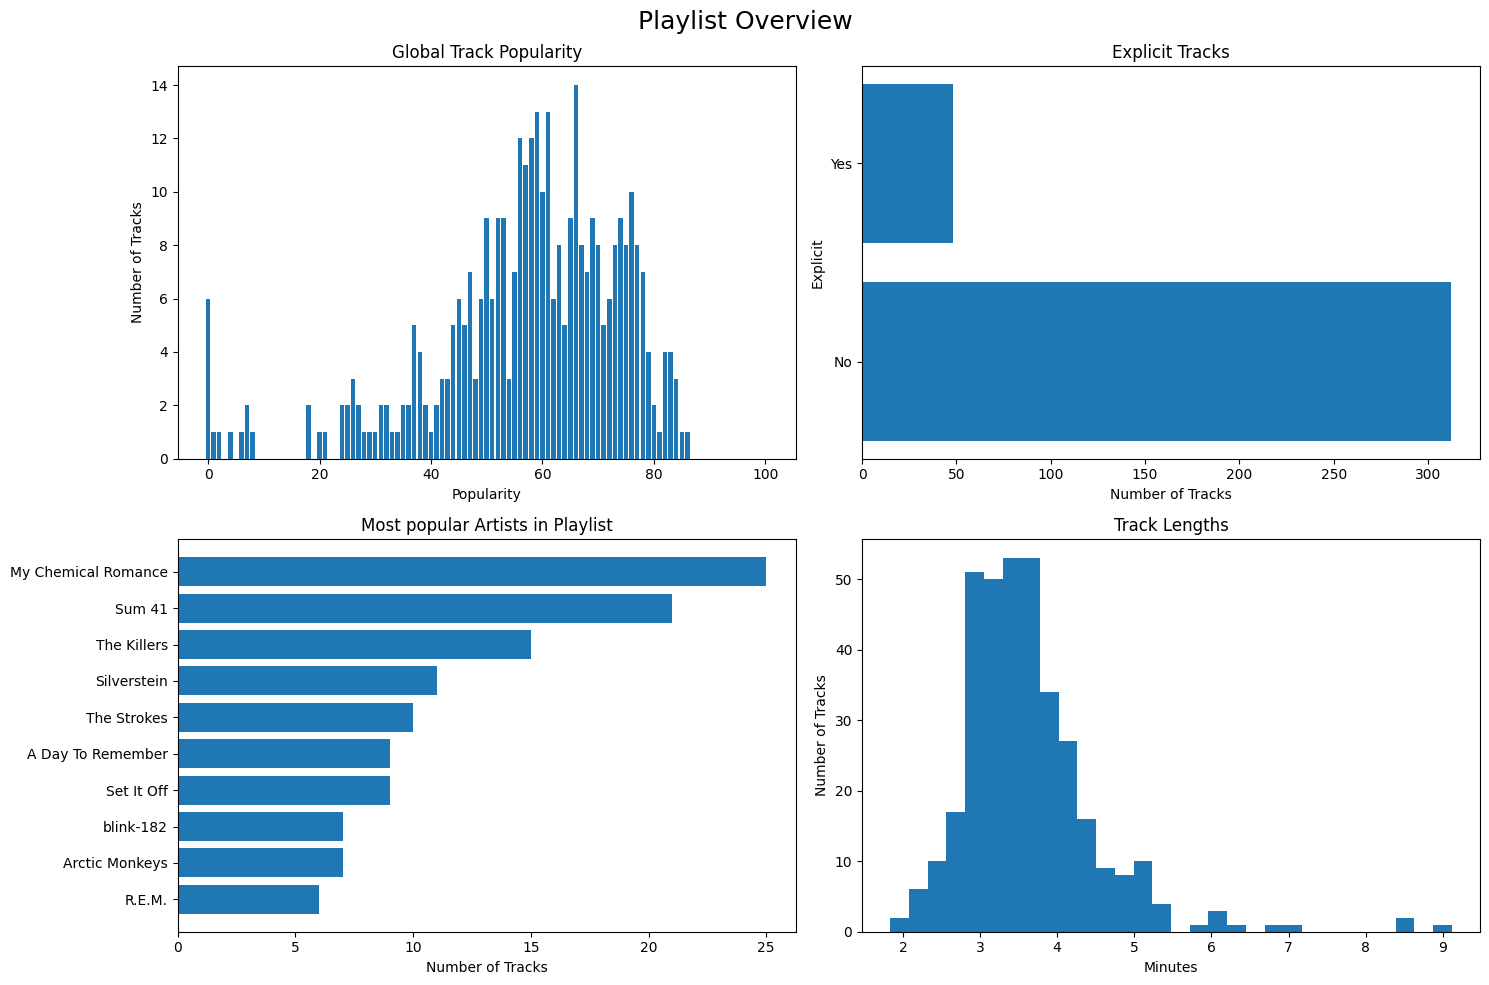

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1
axs[0, 0].bar(playlist_analysis_data["popularity"].keys(), playlist_analysis_data["popularity"].values())
axs[0, 0].set_ylabel('Number of Tracks')
axs[0, 0].set_xlabel('Popularity')
axs[0, 0].set_title('Global Track Popularity')

# Plot 2
axs[0, 1].barh(["No", "Yes"], playlist_analysis_data["explicit_track"].values())
axs[0, 1].set_ylabel('Explicit')
axs[0, 1].set_xlabel('Number of Tracks')
axs[0, 1].set_title('Explicit Tracks')

# Plot 3
axs[1, 0].barh(list(playlist_analysis_data["artists"].keys())[:10][::-1], 
               list(playlist_analysis_data["artists"].values())[:10][::-1])
axs[1, 0].set_xlabel('Number of Tracks')
axs[1, 0].set_title('Most popular Artists in Playlist')


# Plot 4
axs[1, 1].hist(playlist_analysis_data["track_lengths"], bins=30)
axs[1, 1].set_title('Track Lengths')
axs[1, 1].set_xlabel('Minutes')
axs[1, 1].set_ylabel('Number of Tracks')

plt.suptitle("Playlist Overview", size=18)
plt.tight_layout()
plt.show()

In [18]:
checkboxes = [ipywidgets.Checkbox(value=False if num < 3 else True, description=band) for band, num in playlist_analysis_data["artists"].items()]
grid_layout = ipywidgets.GridBox(children=checkboxes, layout=ipywidgets.Layout(
    width='100%',
    height='auto',
    border='1px solid black',
    display='flex',
    flex_flow='row wrap',
    justify_content='space-around',
    padding='0 0px'
))

display(grid_layout)

GridBox(children=(Checkbox(value=True, description='My Chemical Romance'), Checkbox(value=True, description='S…

In [19]:
def get_selected_artists():
    return [checkbox.description for checkbox in checkboxes if checkbox.value]

In [20]:
selected_artists = get_selected_artists()

In [21]:
selected_artists

['My Chemical Romance',
 'Sum 41',
 'The Killers',
 'Silverstein',
 'The Strokes',
 'A Day To Remember',
 'Set It Off',
 'blink-182',
 'Arctic Monkeys',
 'R.E.M.',
 'Anti-Flag',
 'Muse',
 'The Fratellis',
 'Bring Me The Horizon',
 'The Used',
 'The All-American Rejects',
 'The Hives',
 'Bon Jovi',
 'The Cure',
 'Pixies',
 'Bowling For Soup',
 'The Red Jumpsuit Apparatus',
 'Forever The Sickest Kids',
 'Radiohead',
 'Simple Plan',
 'The Buggles',
 'Queen',
 'Fall Out Boy',
 'Keane',
 'Weezer',
 'The Bravery',
 'Busted',
 'Yellowcard',
 'Taking Back Sunday',
 'zebrahead',
 'Sorority Noise']

In [22]:
def get_artist_mbid(artist_name):
    search_url = 'https://musicbrainz.org/ws/2/artist/'
    
    params = {
        'query': artist_name,
        'fmt': 'json'          # Format the response as JSON
    }
    
    headers = {
        'Accept': 'application/json'
    }
    
    response = requests.get(search_url, params=params, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        
        # Check if any artists were found
        if data['artists']:
            return data['artists'][0]['id']  # Return the MBID of the first artist found

        else:
            print('No artist found with that name')
            return None
    else:
        print('Failed to submit query')
        return None

In [23]:
get_artist_mbid(selected_artists[1])

'f2eef649-a6d5-4114-afba-e50ab26254d2'

In [24]:
def get_musicbrainz_artist_info(artist_name):

    mbid = get_artist_mbid(artist_name)
    if mbid is not None:
        url = f'https://musicbrainz.org/ws/2/artist/{mbid}?inc=release-groups&fmt=json'

        response = requests.get(url)
    
        if response.status_code == 200:
            return response.json()
        else:
            print('Failed to submit query. Status Code:', response.status_code)
            return None

    else:
        return None

In [25]:
def get_all_artists_info(artist_list, save_to_file=True):
    all_artists_info = {}

    for artist in tqdm(artist_list):
        all_artists_info[artist] = get_musicbrainz_artist_info(artist)
        time.sleep(2)  # Prevent api overload

    if save_to_file:
        with open(artist_content_save_path, "w") as save_file:
            json.dump(all_artists_info, save_file)

    return all_artists_info

In [26]:
if refetch_data or not os.path.exists(artist_content_save_path):
    all_artists_info = get_all_artists_info(selected_artists)
else:
    with open(artist_content_save_path, "r") as save_file:
        all_artists_info = json.load(save_file)
        print("Loaded data from save file")

Loaded data from save file


In [27]:
all_artists_info

{'My Chemical Romance': {'disambiguation': 'US rock band',
  'id': 'c07f0676-9143-4217-8a9f-4c26bd636f13',
  'life-span': {'begin': '2001-09-12', 'end': None, 'ended': False},
  'isnis': ['0000000121614579'],
  'name': 'My Chemical Romance',
  'sort-name': 'My Chemical Romance',
  'country': 'US',
  'ipis': [],
  'type': 'Group',
  'type-id': 'e431f5f6-b5d2-343d-8b36-72607fffb74b',
  'begin-area': {'disambiguation': '',
   'type-id': None,
   'type': None,
   'sort-name': 'Newark',
   'name': 'Newark',
   'id': '85c7cd5f-6fe2-4195-a44d-69fa390bd6ec'},
  'gender-id': None,
  'end-area': None,
  'release-groups': [{'disambiguation': '',
    'primary-type': 'Album',
    'title': 'I Brought You My Bullets, You Brought Me Your Love',
    'id': 'e8923ffe-6ea0-3a65-b6e4-90bca0a6d3a8',
    'first-release-date': '2002-07-23',
    'secondary-type-ids': [],
    'secondary-types': [],
    'primary-type-id': 'f529b476-6e62-324f-b0aa-1f3e33d313fc'},
   {'secondary-types': [],
    'primary-type-id': 

In [28]:
for artist, artist_info in all_artists_info.items():
    print("\n" + artist + f" ({artist_info['life-span']['begin'][:4]}{' - ' + artist_info['life-span']['end'][:4] if artist_info['life-span']['ended'] else ''})")


My Chemical Romance (2001)

Sum 41 (1996)

The Killers (2001)

Silverstein (2000)

The Strokes (1998)

A Day To Remember (2003)

Set It Off (2008)

blink-182 (1992)

Arctic Monkeys (2002)

R.E.M. (1980 - 2011)

Anti-Flag (1988 - 2023)

Muse (1994)

The Fratellis (2005)

Bring Me The Horizon (2004)

The Used (2001)

The All-American Rejects (2000)

The Hives (1993)

Bon Jovi (1983)

The Cure (1977)

Pixies (1986)

Bowling For Soup (1994)

The Red Jumpsuit Apparatus (2004)

Forever The Sickest Kids (2006)

Radiohead (1991)

Simple Plan (1999)

The Buggles (1977 - 1981)

Queen (1970)

Fall Out Boy (2001)

Keane (1995)

Weezer (1992)

The Bravery (2003 - 2011)

Busted (2001)

Yellowcard (1997)

Taking Back Sunday (1999)

zebrahead (1996)

Sorority Noise (2013 - 2018)


In [29]:
def prepare_date(date_str):
    if len(date_str) == 10:
        return date_str
    elif len(date_str) == 7:
        return date_str + "-01"
    elif len(date_str) == 4:
        return date_str + "-01-01"
    else:
        print("Invalid format:", date_str)
        return "unknown"

In [30]:
prepared_artist_data = []

for artist, artist_info in all_artists_info.items():

    releases = []
    for release in artist_info["release-groups"]:    
        releases.append({
            "name": release['title'],
            "type": release['primary-type'],
            "date": prepare_date(release['first-release-date'])
        })
    
    artist_dict = {"name": artist, 
                   "start": prepare_date(artist_info['life-span']['begin']),
                   "end": None if artist_info['life-span']['end'] is None else prepare_date(artist_info['life-span']['end']),
                   "releases": releases}
    
    prepared_artist_data.append(artist_dict)

Invalid format: 
Invalid format: 
Invalid format: 


In [31]:
prepared_artist_data

[{'name': 'My Chemical Romance',
  'start': '2001-09-12',
  'end': None,
  'releases': [{'name': 'I Brought You My Bullets, You Brought Me Your Love',
    'type': 'Album',
    'date': '2002-07-23'},
   {'name': 'Three Cheers for Sweet Revenge',
    'type': 'Album',
    'date': '2004-06-08'},
   {'name': 'The Black Parade', 'type': 'Album', 'date': '2006-10-20'},
   {'name': 'Danger Days: The True Lives of the Fabulous Killjoys',
    'type': 'Album',
    'date': '2010-11-05'},
   {'name': 'The Black Parade / Living with Ghosts (The 10th Anniversary Edition)',
    'type': 'Album',
    'date': '2016-01-01'},
   {'name': 'The Black Parade (Deluxe Edition)',
    'type': 'Album',
    'date': 'unknown'},
   {'name': 'Conventional Weapons', 'type': 'Album', 'date': '2013-02-05'},
   {'name': 'May Death Never Stop You: The Greatest Hits 2001–2013',
    'type': 'Album',
    'date': '2014-03-21'},
   {'name': 'Living with Ghosts', 'type': 'Album', 'date': '2016-09-23'},
   {'name': 'Life on the M

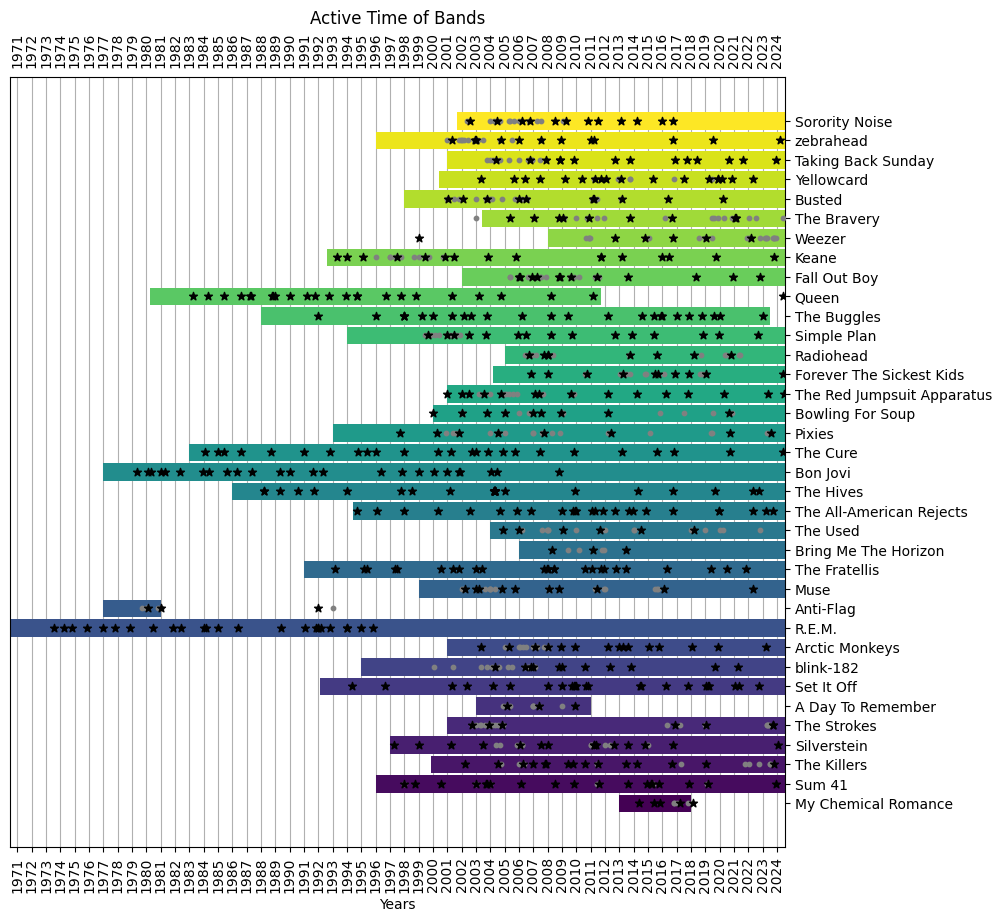

In [38]:
current_date = datetime.now()

N = len(prepared_artist_data)
colors = cm.viridis(np.linspace(0, 1, N))

fig, ax = plt.subplots(figsize=(10, 10))

# Add horizontal bars for each band
for i, band_info in enumerate(prepared_artist_data[::-1]):
    
    end = current_date if band_info["end"] is None else datetime.strptime(band_info["end"], '%Y-%m-%d')
    start = datetime.strptime(band_info["start"], '%Y-%m-%d')
    
    ax.barh(i, (end - start).days, left=start, height=.9, align='center', color=colors[i])
    
    # Add points for each release
    for release in band_info['releases']:
        try:
            release_date = datetime.strptime(release['date'], '%Y-%m-%d')
            if release["type"] == "Album":
                ax.scatter(release_date, i, color='black', marker="*", s=35, zorder=5)  # zorder to ensure points are on top
            elif release["type"] == "Single":
                ax.scatter(release_date, i, color='grey', marker="o", s=10, zorder=4)
        except ValueError:  # Unknown release date
            pass

# Set the y-axis labels to the band names
ax.set_yticks(range(len(prepared_artist_data)))
ax.set_yticklabels([band["name"] for band in prepared_artist_data])
ax.yaxis.set_tick_params(labelright=True, labelleft=False)
ax.yaxis.tick_right()
ax.xaxis.set_tick_params(labeltop=True)

# Format the x-axis to display dates
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

earliest_start_date = datetime.strptime(min(prepared_artist_data, key=lambda x: x["start"])["start"], '%Y-%m-%d')
ax.set_xlim([earliest_start_date, current_date])

# Rotate x-axis labels by 90 degrees
for label in ax.get_xticklabels():
    label.set_rotation(90)

# Optionally, add grid lines and labels
ax.grid(True, axis='x')
ax.set_axisbelow(True)
plt.xlabel('Years')
plt.title('Active Time of Bands')

# Show the plot
plt.show()